## ERDOS
Create a synthetic graph from the synthetic input graph created using the Erdos Reny methods.

In [1]:
# import modules
import os
os.chdir('..')
print(os.getcwd())

import pickle
from tigger_package.orchestrator import Orchestrator
from tigger_package.tools import plot_adj_matrix
import networkx as nx 
import pandas as pd
import time
GRID_SEARCH = False
folder = "data/erdos/"

/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj
loaded


## GRAPHSAGE hyperparam

In [2]:
# Gridsearch train graphsage
if GRID_SEARCH:
    orchestrator = Orchestrator(folder)
    grid_res = orchestrator.lin_grid_search_graphsage({"embedding_dim": [32, 64, 128]})


Epoch: 1499, Loss: 0.6853,  Test: 0.6820Total training time 37225.9975s


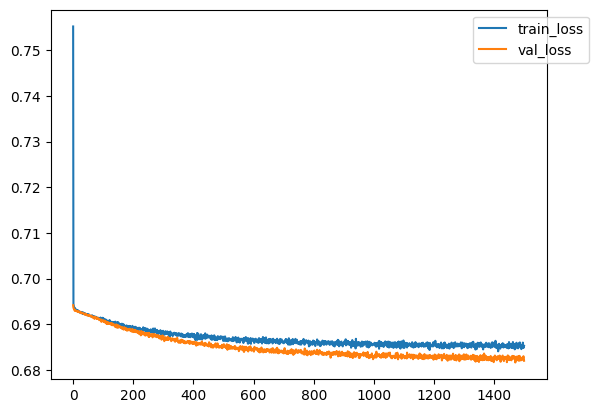

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


In [3]:

orchestrator = Orchestrator(folder)
train_metrics = orchestrator.create_graphsage_embedding()


In [4]:
# save results
import pickle
train_config = orchestrator.config.copy()
train_config['metrcis'] = train_metrics
res_filename = folder + 'exp_results/graphcase_final_run_metrics.pickle'
pickle.dump(train_config, open(res_filename, 'wb'))

In [5]:
# convert final embedding to csv for tensorflow embedding viewer
import pandas as pd
embed = pd.read_parquet(folder + "embed/embedding.parquet")
embed.to_parquet(folder + "embed/embedding_final.parquet")
embed.to_csv(folder + "embed/embedding_final.csv", sep='\t', header=False, index=False, )
# embed.hist(figsize=(20,20), bins=20)

## flownet training

In [6]:
if GRID_SEARCH:
    orchestrator = Orchestrator(folder)
    start = time.time()
    # res = orchestrator.lin_grid_search_flownet({"learning_rate": [0.0001, 0.001]})
    # res = orchestrator.lin_grid_search_flownet({"number_of_bijectors": [16,8,4]})
    # res = orchestrator.lin_grid_search_flownet({"hidden_units": [[4,4], [8,8], [16,16]]})
    res = orchestrator.lin_grid_search_flownet({"activation": ['sigmoid', 'relu', 'leaky_relu']})
    end = time.time()
    print(f"Duration: {end-start}")
    # -185.87 val

Epoch 5981/6000  ['loss:-176.59738159179688', 'val_loss:-160.68101501464844']

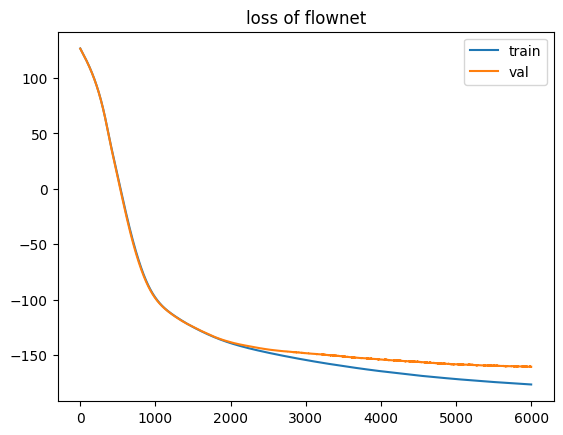

In [7]:
#final flow model
orchestrator = Orchestrator(folder)
name, history = orchestrator.train_flow()
#1m39 val_loss -4

In [8]:
# save results
train_config = orchestrator.config.copy()
train_config['metrics'] = history.history
res_filename = folder + 'exp_results/flownet_final_run_metrics.pickle'
pickle.dump(train_config, open(res_filename, 'wb'))

In [9]:
# convert final embedding to csv for tensorflow embedding viewer
filepath = orchestrator.config_path + orchestrator.config['flownet']['flownet_config_path']
obj = pickle.load(open(filepath + name, 'rb'))
pickle.dump(obj,open(filepath + "final_flowmodel.pickle", 'wb'))

## sample flownet

In [10]:
# Sample flow net
orchestrator.sample_flownet()

In [11]:

# convert final embedding to csv for tensorflow embedding viewer
import pandas as pd
embed = pd.read_parquet(folder + 'synth_nodes.parquet')
embed.to_parquet(folder + 'synth_nodes_final.parquet')
embed.to_csv(folder + "synth_nodes_files.csv", sep='\t', header=False, index=False, )

In [12]:
orchestrator = Orchestrator(folder)
orig_node = orchestrator._load_nodes()
orig_embed = orchestrator.load_normalized_embed()
x_data = orig_embed.join(orig_node, how='inner')


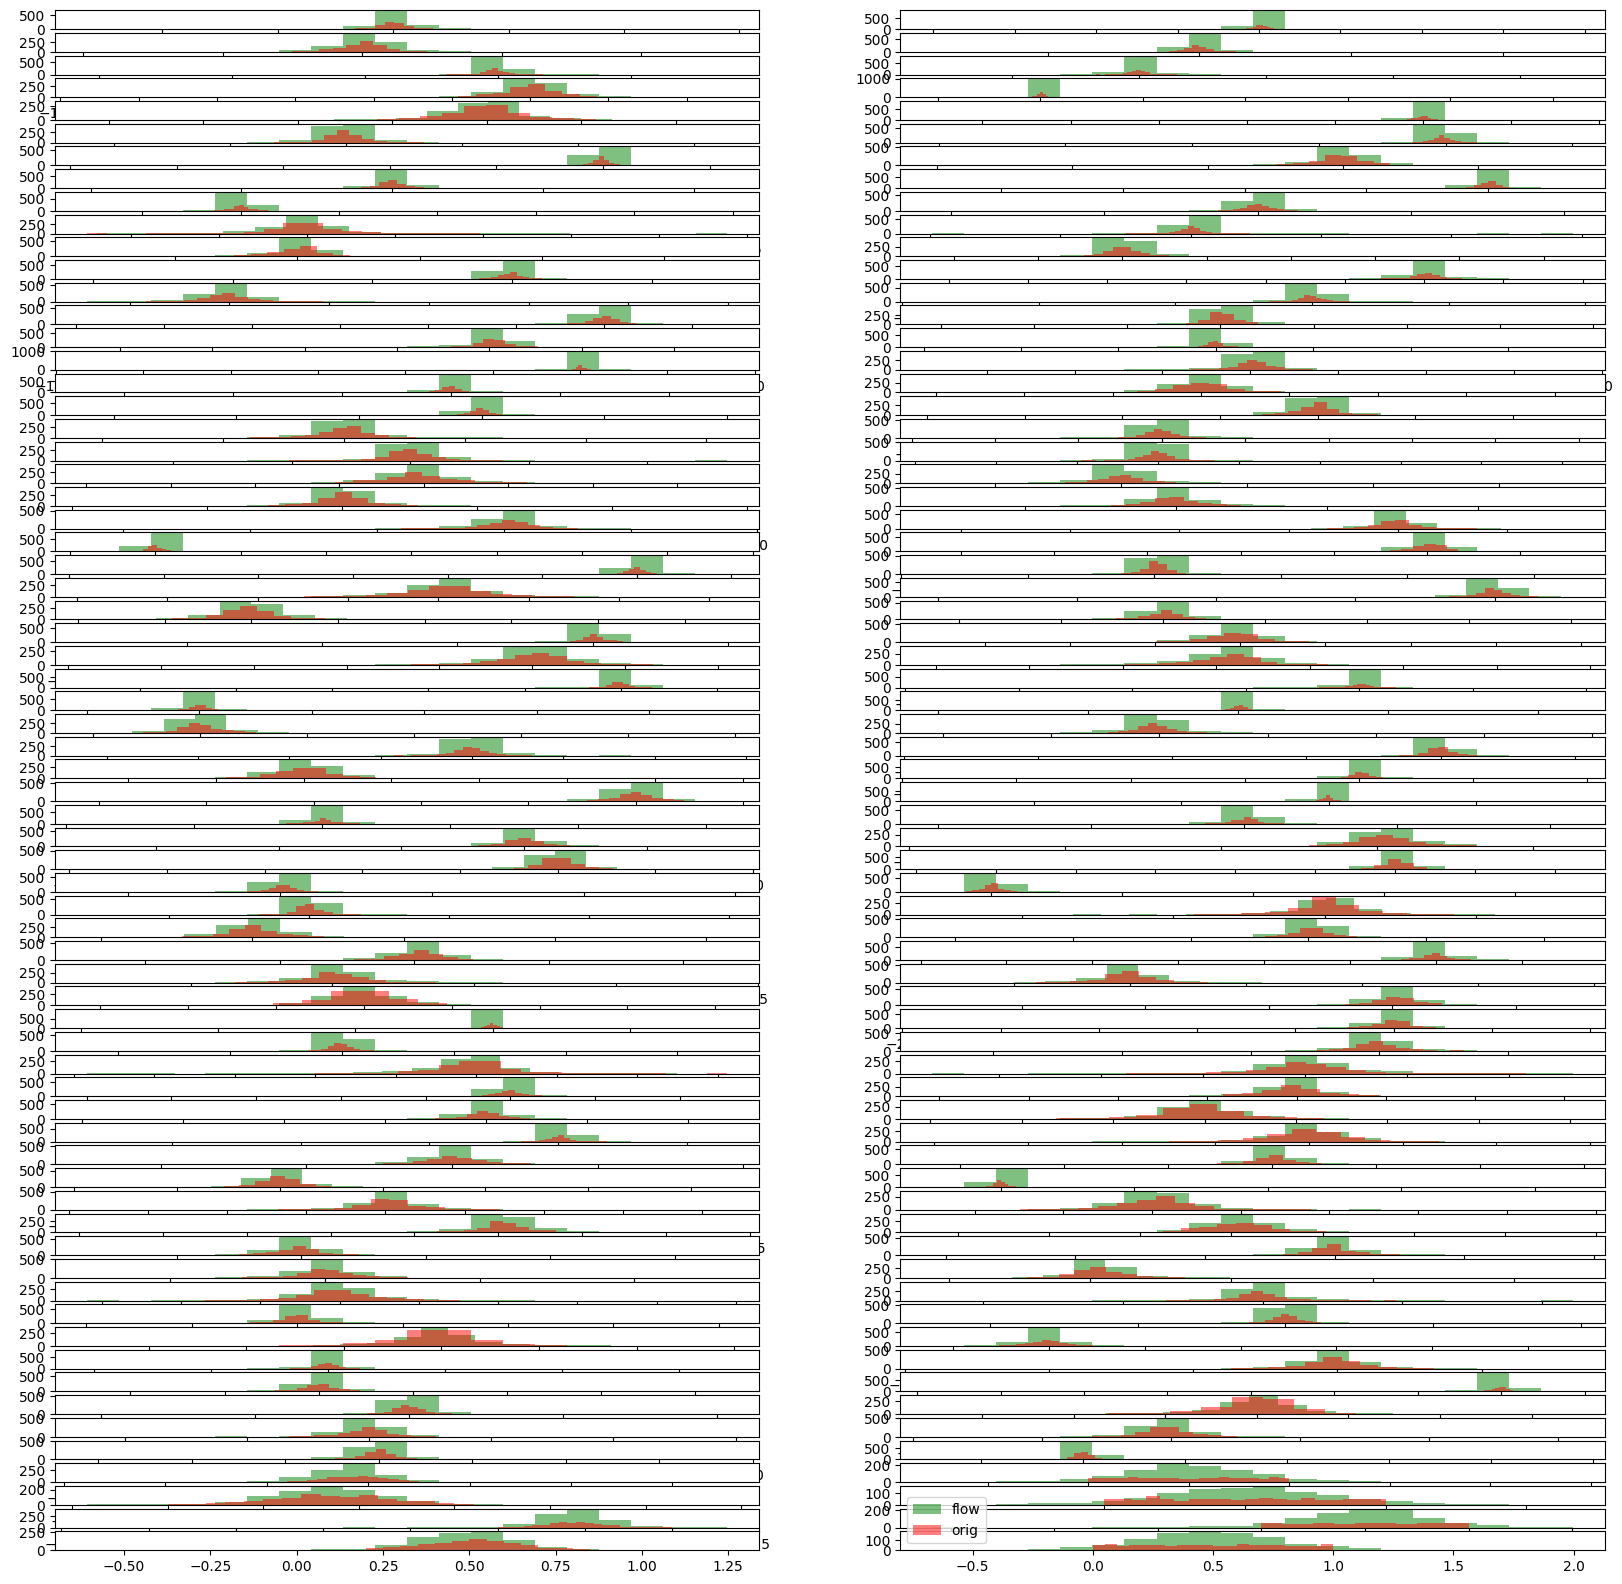

In [13]:
# plot samples embedding
import matplotlib.pyplot as plt
import math
fig = plt.figure(figsize=(20,20))
dim = embed.shape[1]
for i in range(dim):
    ax = fig.add_subplot(math.ceil(dim/2),2, i+1)
    ax.hist(embed.loc[:, i], bins=20, alpha=0.5, color='g', label='flow')
    ax.hist(x_data.iloc[:, i], bins=20, alpha=0.5, color='r', label='orig')

plt.legend()
plt.show()


## train lstm

In [15]:
orchestrator = Orchestrator(folder)
# res = orchestrator.lin_grid_search_lstm({'lr': [0.001, 0.0005, 0.0001]})
# res = orchestrator.lin_grid_search_lstm({'num_clusters': [16, 64, 128]})
# res = orchestrator.lin_grid_search_lstm({'nb_lstm_layers': [1,2]})

loss_dict = orchestrator.train_lstm()
# 
# !!! checken cluster embedding !!!

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/99549 [00:00<?, ?it/s]

Number of components, 130


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

 6144 / 8000, epoch:0 loss=0, val_loss: 0

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: list index out of range

In [27]:
# create synthetic walks
orchestrator.create_synthetic_walks(target_cnt=200000, map_real_time=False)
obj = pickle.load(open(folder + 'synth_walks.pickle', 'rb'))
pickle.dump(obj, open(folder + 'synth_walks_final.pickle', 'wb'))

## create synthetic graph

In [28]:
orchestrator = Orchestrator(folder)
orchestrator.generate_synth_graph()

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/99549 [00:00<?, ?it/s]

Number of components, 18


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [29]:
embed = pd.read_parquet(folder + 'synth_graph/node_attributes.parquet')
embed.to_parquet(folder + 'synth_graph/node_attributes_final.parquet')
embed = pd.read_parquet(folder + 'synth_graph/adjacency.parquet')
embed.to_parquet(folder + 'synth_graph/adjacency_final.parquet')